### Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp
import seaborn as sns
from scipy import stats

sns.set()

### Data Analysis

In [2]:
# Read data
dfSales = pd.read_csv("avocado_sales.csv")
dfSales["date"] = pd.to_datetime(dfSales["date"])
dfSales.head()

,date,sales,price
0,2021-01-01,1031,1.21
1,2021-01-02,2969,1.18
2,2021-01-03,2419,1.23
3,2021-01-04,2525,1.20
4,2021-01-05,2517,1.19


In [3]:
# Descriptive statistics
dfSales.describe()

,sales,price
count,63.000000,63.000000
mean,2029.047619,1.199048
std,598.363101,0.010733
min,735.000000,1.180000
25%,1716.500000,1.190000
50%,2083.000000,1.200000
75%,2402.500000,1.210000
max,3421.000000,1.230000


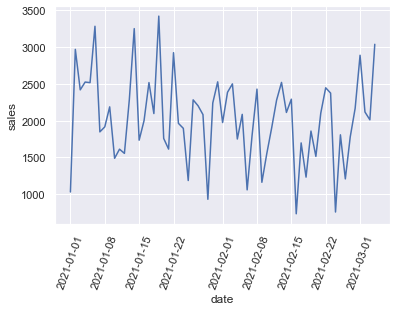

In [4]:
# Time series data of sales
sns.lineplot(x="date", y="sales", data=dfSales)
plt.xticks(rotation=70)
plt.show()

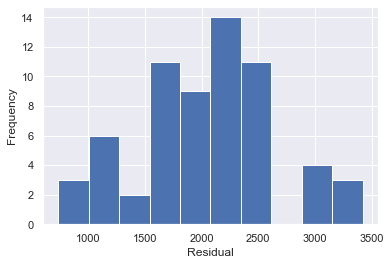

In [5]:
# Demand distribution
plt.hist(dfSales["sales"])
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

### Deterministic model

The deterministic model is typically written in terms of the averages (expectations) of the demand, the common uncertain element. 

In our particular problem for this class, we do not need to formulate a mixed-integer linear program because the solution of the deterministic model is straightforward (which is it?)

In [6]:
# Picking the average
z = dfSales["sales"].mean()

In [7]:
# Function to evaluate the cost of the solution based on history (counterfactual)
def solcost(x):
    numsamples = dfSales.shape[0]
    return  (
        (1.0/numsamples) * 
            sum( [1.2 * max(d - x, 0) + 0.25 * max(x - d, 0) for d in dfSales["sales"] ] )
    )

In [8]:
print("Solution cost:", solcost(z))

Solution cost: 334.8688964474678


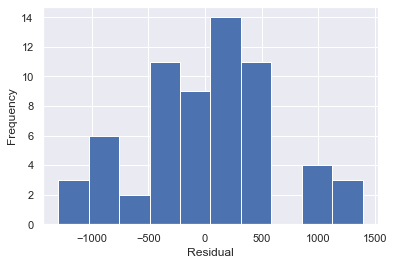

In [9]:
# Checking the residuals (p.s.: ideally you would do out-of-sample)
residuals = [ d - z for d in dfSales["sales"] ]

# Residual distribution
plt.hist(residuals)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [10]:
# Residual stats
print( "mean residual:", np.mean(residuals) )
print( "std residual:", np.std(residuals) )

mean residual: 1.804552979708191e-14
std residual: 593.5951917769216


### Non-parametric formulation

<b>Variables</b>

In [11]:
# Import PuLP modules
import pulp

# Initialize model and objective sense
nonparamModel = pulp.LpProblem(name="NonParametric", sense=pulp.LpMinimize)

# Our main decision variable: z
zvar = pulp.LpVariable("z", lowBound=0.0, cat=pulp.LpContinuous)

# Sample the dataset
samples = range(0, dfSales.shape[0])

# Demand loss and extra supply variables per possible scenario (represented by the samples)
lvar = pulp.LpVariable.dict("l", samples, lowBound=0.0)
svar = pulp.LpVariable.dict("s", samples, lowBound=0.0)

<b>Constraints</b>

In [12]:
# Create constraints
sales = np.array(dfSales["sales"])

for s in samples:
    # Demand loss
    nonparamModel += ( lvar[s] >= sales[s] - zvar )
    # Extra supply
    nonparamModel += ( svar[s] >= zvar - sales[s] )

<b>Objective Function</b>

In [13]:
# Objective function
r = 1.20
c = 0.25 
obj = pulp.lpSum([ r * lvar[s] for s in samples ])
obj += pulp.lpSum([ c * svar[s] for s in samples ])

# Add objective to model
nonparamModel += 1/len(samples) * obj

<b>Solution</b>

In [14]:
# Write LP to file (optional, but often good to find errors)
nonparamModel.writeLP("nonparam.lp")

# Solve model
nonparamModel.solve()
print("Status:", pulp.LpStatus[nonparamModel.status])

Status: Optimal


<b>Analyzing the solution</b>

In [15]:
# Expected cost:
expectedCost = pulp.value(nonparamModel.objective)
print("Expected value: " + str(expectedCost))

Expected value: 218.16825396825396


In [16]:
# Optimal "z"
z = zvar.value()
z

2518.0

In [17]:
# Notice that the expected objective should match the optimal objective above
print("Solution cost:", solcost(z))

Solution cost: 218.16825396825396


In [18]:
# What did we get before?
dfSales["sales"].mean()

2029.047619047619

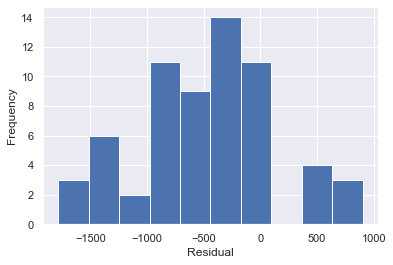

In [19]:
# Analyze residuals of this new solution
residuals = [ d - z for d in dfSales["sales"] ]
plt.hist(residuals)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [20]:
# Residual stats
print( "mean residual:", np.mean(residuals) )
print( "std residual:", np.std(residuals) )

mean residual: -488.95238095238096
std residual: 593.5951917769216


<b>Question:</b> Is this a better solution? Or worse? Why do you think the model decreased the mean residual?

### Parametric formulation

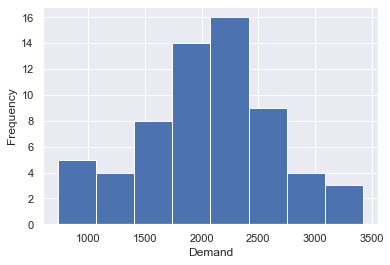

In [21]:
# Analyzing demand distribution
dfSales["sales"].hist(bins=8)
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.show()

Looks like a Normal. Maybe one extra test can help us gather more evidence

In [22]:
stats.normaltest(dfSales["sales"])

NormaltestResult(statistic=0.07205007319854305, pvalue=0.9646161424729848)

Computing the <b>optimal</b> (leveraging problem structure)

In [23]:
# What is the optimal?
salesDist = stats.norm(dfSales["sales"].mean(), dfSales["sales"].std())
zopt = salesDist.ppf( r/(r+c) )
zopt

2594.3030453984693

In [24]:
# Let's check the solution cost - why is it larger than before if optimal?
print("Solution cost:", solcost(zopt))

Solution cost: 224.51344530526057


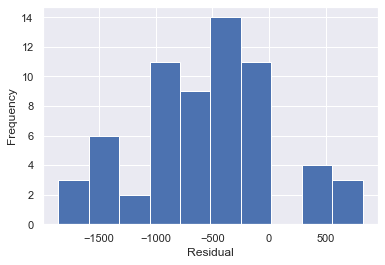

In [25]:
# Analyze residuals
residuals = [ d - zopt for d in dfSales["sales"] ]
plt.hist(residuals)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()